# Regressing out covariates
Today on 3/16/2023 I had a hell of a day at work trying to figure out Seurat's `vars.to.regress` in the `ScaleData` function. Here is my epithany post on github [ScaleData with do.center=F got the same result as do.center=T #5503](https://github.com/satijalab/seurat/issues/5503#issuecomment-1472938523).

Well, what I realized is 
* What regressing out a variable means
* What residuals are and what they are used for in this context
* What would be an analogous toy dataset.

**Here is my toy dataset:** Imagine ordered a breed of mouse called the *long hair mouse (LHM)* from a breeder. We want to test whether this mouse really has longer hair or not from normal WT mice. So we get 20 LHM mice and 20 WT mice and measure their furs.

In [59]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind as ttest

### Examining the data

In [137]:
df = pd.read_csv('toy_mouse_example.csv')
df.loc[:,['hair_length','breed']].head()

,hair_length,breed
0,4.057766,WT
1,3.922743,WT
2,4.082894,WT
3,3.787958,WT
4,4.240086,WT


In [138]:
df.groupby('breed').hair_length.describe()

,count,mean,std,min,25%,50%,75%,max
breed,,,,,,,,
LHM,20.0,3.992750,0.193719,3.548892,3.875978,4.005588,4.083404,4.310995
WT,20.0,4.015731,0.202340,3.640154,3.871712,4.052519,4.100297,4.464038


Huh, the two breeds don't look too different! Both have a mean around 4 and a STD of about 0.2... Maybe we got ripped off, lets plot and do a T-test

### Testing my LHM vs WT

<AxesSubplot:xlabel='hair_length', ylabel='Density'>

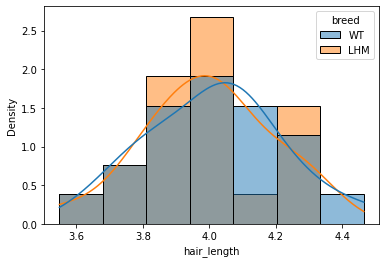

In [139]:
sns.histplot(data = df[['hair_length', 'breed']], x = 'hair_length', hue = 'breed', 
             fill=True, stat="density", common_norm=False, kde=True)

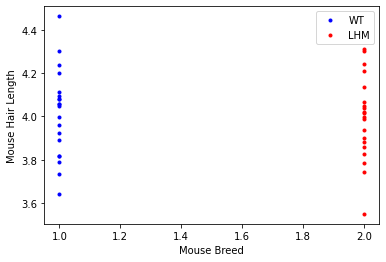

In [235]:
plt.plot([1 for i in range(20)], df['hair_length'][df.breed == 'WT'], linewidth = 0, marker = '.', c='blue', label ='WT')
plt.plot([2 for i in range(20)], df['hair_length'][df.breed == 'LHM'], linewidth = 0, marker = '.', c='red', label = 'LHM')
plt.xlabel("Mouse Breed")
plt.ylabel("Mouse Hair Length")
plt.legend()

In [140]:
ttest(df["hair_length"][df.breed == 'WT'], 
      df["hair_length"][df.breed == 'LHM'])

Ttest_indResult(statistic=0.366904352574, pvalue=0.7157256746927099)

Visually looking at the data there doesn't seem to be a huge difference in distribution, and conducting a test yields an insignificant p-value. Therefore we don't have enough evidence to reject the null hypothesis that my two mouse populations are the same. 

SMH WE GOT RIPPED OFF!!! Is what I would say, but I know a little secret! Turns out my mouse breeder recorded the ages of the mice and provided us with some extra meta data. Let us see if there is a difference between the hair lengths of different aged mice.

In [141]:
df.head()

,age,hair_length,breed
0,2.025478,4.057766,WT
1,2.034290,3.922743,WT
2,2.022872,4.082894,WT
3,1.852754,3.787958,WT
4,2.081706,4.240086,WT


<AxesSubplot:xlabel='age', ylabel='Count'>

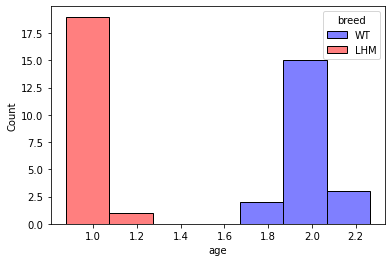

In [219]:
sns.histplot(df, x = 'age', hue = 'breed', palette = ['blue', 'red'])

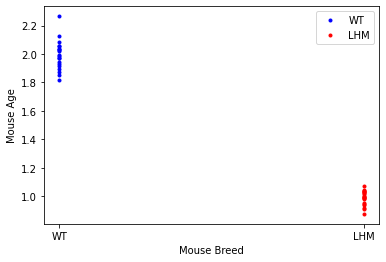

In [236]:
plt.plot(df['breed'][df.breed == 'WT'], df['age'][df.breed == 'WT'], linewidth = 0, marker = '.', c='blue', label='WT')
plt.plot(df['breed'][df.breed == 'LHM'], df['age'][df.breed == 'LHM'], linewidth = 0, marker = '.', c='red', label='LHM')
plt.xlabel("Mouse Breed")
plt.ylabel("Mouse Age")
plt.legend()

Huh, looking at the ages of my two mouse breeds, there seems to be a very strong association between age and breed. The breeder seems to have sent us normal mice that are about a year older than the LHM. Maybe that extra year meant that the mice had more time to grow more hair. There is hope for our mouse breeder's reputation! Lets plot the hair length against age to see if they are associated.

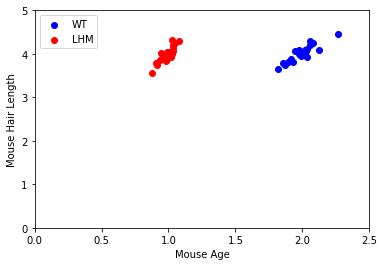

In [159]:
plt.scatter(df.age[df.breed == 'WT'], df.hair_length[df.breed == 'WT'], 
            c = 'blue', label = 'WT')
plt.scatter(df.age[df.breed == 'LHM'], df.hair_length[df.breed == 'LHM'], 
            c = 'red', label = 'LHM')
plt.xlim(0,2.5)
plt.ylim(0,5)
plt.xlabel("Mouse Age")
plt.ylabel("Mouse Hair Length")
plt.legend()

Sure enough, there seem to be associations. Here comes the actual regression.

### Regressing the effect of age
When we regress away a variable, what we are actually doing is generating a good guess of what our outcome variable Y (in this case that is hair_length) *should be* at a given age in each of the groups we want to remove. 

$HairLength = B_1Age + B2$

Now I'm not sure if what I'm about to do is technically the best generalized method, but I'm going to fit this model to only one 'reference' group, in this case the WT condition, and the residuals between this fit and my points should contain the corrected information. 

$Residual = Actual - Predicted$

$Corrected = Actual - Batch Effect$

Eyeballing the graph above, my guess would be that the blue dots create a line with a slope of about 1.4 hair_lengths / year with a y-intercept of about 0.75. This would be my predictions for how long a mouses hair should be for a given age, and we use the formula above to calculate our corrected (residual) value.

In [252]:
ref_group = 'WT'
a, b = np.polyfit(df.age[df.breed == ref_group], df.hair_length[df.breed == ref_group], 1)
# a, b = np.polyfit(df.age, df.hair_length,1)

Text(0.2, 4, 'b = 0.49')

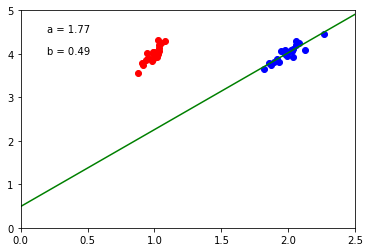

In [253]:
plt.scatter(df.age[df.breed == 'WT'], df.hair_length[df.breed == 'WT'], 
            c = 'blue', label = 'WT')
plt.scatter(df.age[df.breed == 'LHM'], df.hair_length[df.breed == 'LHM'], 
            c = 'red', label = 'LHM')
plt.xlim(0,2.5)
plt.ylim(0,5)

x = np.linspace(start=0,stop=2.5,num=10)
y = a*x + b
plt.plot(x,y, c = 'green', label = 'fit')
plt.text(0.2,4.5, f'a = {round(a,2)}')
plt.text(0.2,4, f'b = {round(b,2)}')

In [254]:
hair_residuals = df.hair_length - (a * df.age + b)
df["hair_residuals"] = hair_residuals
df.hair_residuals = hair_residuals

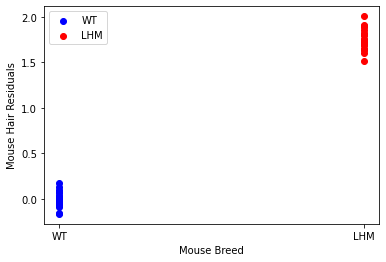

In [255]:
plt.scatter(df.breed[df.breed == 'WT'], df["hair_residuals"][df.breed == 'WT'], c = 'blue', label = 'WT')
plt.scatter(df.breed[df.breed == 'LHM'], df["hair_residuals"][df.breed == 'LHM'], c = 'red', label = 'LHM')
plt.xlabel("Mouse Breed")
plt.ylabel("Mouse Hair Residuals")
plt.legend()

<AxesSubplot:xlabel='hair_residuals', ylabel='Density'>

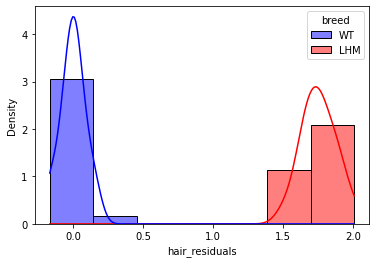

In [256]:
sns.histplot(data = df, x = 'hair_residuals', hue = 'breed', 
             fill=True, stat="density", common_norm=False, kde=True, palette=['blue', 'red'])

Fitting to one of the age groups as a frame of reference shows us that indeed when we remove the effects of age, the LHM have 2x the amount of hair as the WT mice. Let us re-do the statistical test on this new point of view and see if there is a statistically significant result.

In [257]:
ttest(df["hair_residuals"][df.breed == 'WT'], df["hair_residuals"][df.breed == 'LHM'])

Ttest_indResult(statistic=-52.511863367362594, pvalue=4.417577721245282e-37)

### Conclusion
When we have two sets of data, we want to make our samples as similar to each other as possible. Obviously we cannot account for all variation, but if we know some differences will exist we should take them into account and statistically deal with them. With this regression technique, we effectively removed the confounding effect of age and the result we get seems readily interpretable.

My interpretation is that LHM have about 2 hair units above the expected hair of a WT mouse of the same age. This regressing out technique didn't give me information on rates of hair growth (the line fit did, but I'm not really directly absorbing that info). It is however directly telling me that a LHM will have.

### Feedback
1. Farshad says that people generally don't make a reference group to fit on, they fit on the whole data and that is supposed to work. My data doesn't act that way though and fitting on all the data not just a reference group produces garbage. Need to figure out how cases like mine are handled. I need to revisit [Children smoking dataset 2.11 Confounding: Statistically Checking And Adjusting For It In R](https://www.youtube.com/watch?v=f_i6NPUA8wM) on youtube.

# Making my toy_mouse_example.csv

In [129]:
# Age vs Hair length plots
def hair_length(age, rate_of_growth):
    return(age * rate_of_growth)

In [133]:
ages_WT = np.random.normal(loc=2, scale = 0.1, size = 20)
ages_LHM = np.random.normal(loc=1, scale = 0.05, size = 20)
hair_length_WT_wiggle = np.random.normal(loc=0, scale = 0.1, size = 20)
hair_length_WT = np.apply_along_axis(hair_length, axis = 0, arr = ages_WT, rate_of_growth = 2) + hair_length_WT_wiggle
hair_length_LHM_wiggle = np.random.normal(loc=0, scale = 0.1, size = 20)
hair_length_LHM = np.apply_along_axis(hair_length, axis = 0, arr = ages_LHM, rate_of_growth = 4) + hair_length_LHM_wiggle

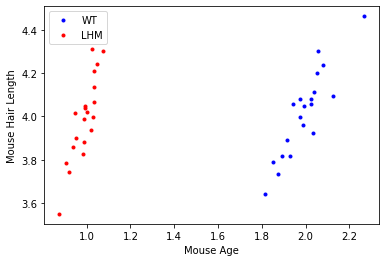

In [238]:
plt.plot(ages_WT, hair_length_WT, c = 'blue', marker = '.', linewidth = 0, label = 'WT')
plt.plot(ages_LHM, hair_length_LHM, c = 'red', marker = '.', linewidth = 0, label = 'LHM')
plt.xlabel("Mouse Age")
plt.ylabel("Mouse Hair Length")
plt.legend()

In [135]:
df = pd.DataFrame({'age': np.concatenate([ages_WT,ages_LHM]), 'hair_length': np.concatenate([hair_length_WT,hair_length_LHM]), 'breed': ['WT']*20 + ['LHM']*20})

In [136]:
# df.to_csv("toy_mouse_example.csv", index=False)